In [1]:
import sys, os, os.path
if not 'EXPERIMENT_HOME' in os.environ: # Configure local paths if not already defined
    ML_HOME = os.path.abspath(os.path.join("..", "..","ml_home")) # ML workspace
    EXPERIMENT_HOME = os.path.abspath(os.path.join(ML_HOME, "..")) # Experiment workspace
    DATA_HOME = os.path.abspath(os.path.join(EXPERIMENT_HOME,"dataset")) # Dataset location
    os.environ["EXPERIMENT_HOME"] = EXPERIMENT_HOME
    os.environ["DATA_HOME"] = DATA_HOME
    sys.path.insert(0, EXPERIMENT_HOME)
    sys.path.insert(0, ML_HOME) # Add to path so can load our library
    os.chdir(EXPERIMENT_HOME) # Change working directory to experiment workspace
print("Experiment Home: ", os.path.abspath(os.curdir), "; Data Home:", DATA_HOME)

Experiment Home:  /home/jovyan ; Data Home: /home/jovyan/dataset


# ARIMA Model - BaseExperiment Instance

In [2]:
from data.pilot import load_pilot_series, list_pilot_series

# list_pilot_series()
dataset = load_pilot_series()


Loading: AOT
Loading: AP
Loading: BTS
Loading: CPF
Loading: KBANK
Loading: KSL
Loading: LH
Loading: PTT
Loading: RATCH
Loading: SCB
Loading: SET
Loading: SET100
Loading: SET50


In [3]:
import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import lag_plot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [4]:

# Load data series and clean-up missing values
def prep_series_for_ARIMA(df):
    """Returns dataframe specific to ARIMA model"""
    # date_time = pd.to_datetime(df.pop('Date'), format='%Y-%m-%d')
    # df['Daily Return'] = np.log(df['Adj Close']/df['Adj Close'].shift())
    # df[['Adj Close', 'Daily Return']]
    # df.dropna(inplace=True)
    # df.head() # Starting data without date column
    if df['Type'][0] == 'StockIndex':
        df['Daily Return'] = df['Change %']
        df['y_true'] = df['Close']
    else:
        df['Daily Return'] = df['DailyReturn']
        df['y_true'] = df['Close']
    df['t'] = df.index

    return df

df_series = prep_series_for_ARIMA(dataset['SET50'])
df_series.head()

,Date,Price,Open,High,Low,Vol.,Change %,Close,Volume,Date.1,Ticker,Type,Daily Return,y_true,t
Date,,,,,,,,,,,,,,,
2015-01-05,2015-01-05,987.40,1002.19,1003.83,986.94,674.13M,-1.36,987.40,6.741300e+08,2015-01-05,SET50,StockIndex,-1.36,987.40,2015-01-05
2015-01-06,2015-01-06,980.50,974.75,981.66,967.74,1.05B,-0.70,980.50,1.050000e+09,2015-01-06,SET50,StockIndex,-0.70,980.50,2015-01-06
2015-01-07,2015-01-07,998.05,980.88,998.10,980.18,784.32M,1.79,998.05,7.843200e+08,2015-01-07,SET50,StockIndex,1.79,998.05,2015-01-07
2015-01-08,2015-01-08,"1,013.24",1009.68,1015.52,1008.11,1.07B,1.52,1013.24,1.070000e+09,2015-01-08,SET50,StockIndex,1.52,1013.24,2015-01-08
2015-01-09,2015-01-09,"1,017.87",1018.89,1019.91,1013.03,813.37M,0.46,1017.87,8.133700e+08,2015-01-09,SET50,StockIndex,0.46,1017.87,2015-01-09


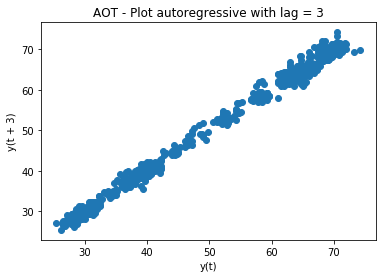

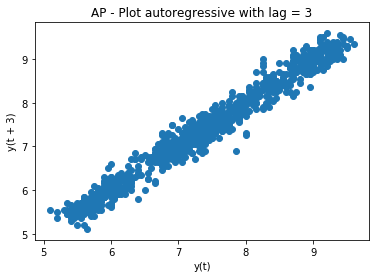

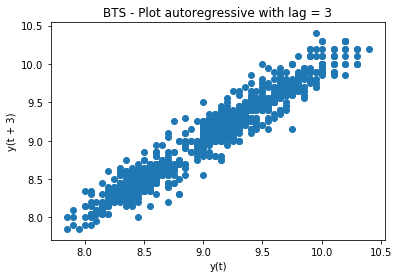

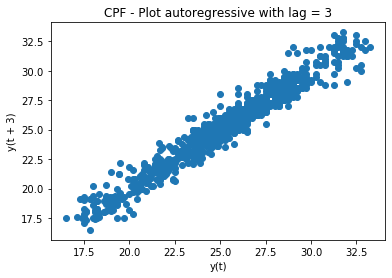

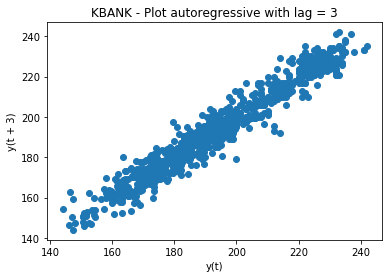

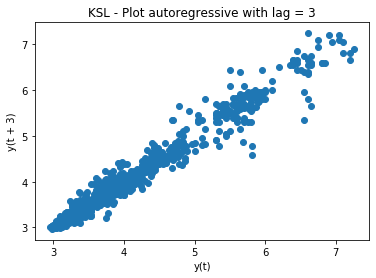

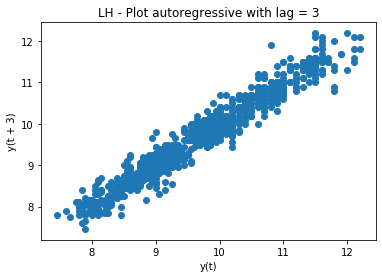

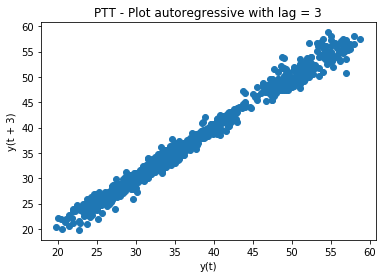

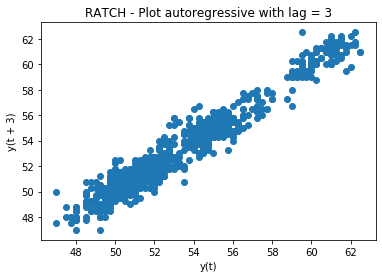

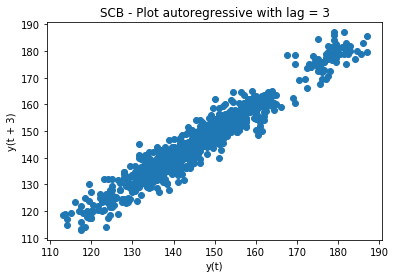

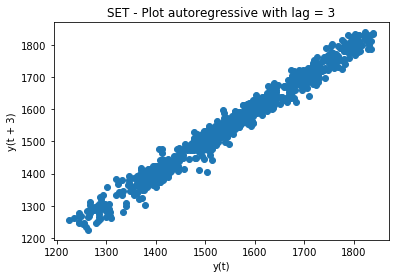

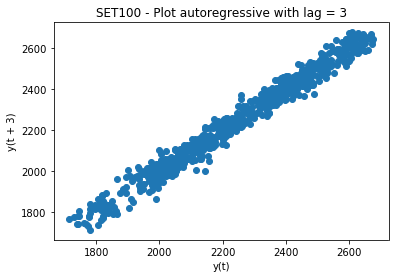

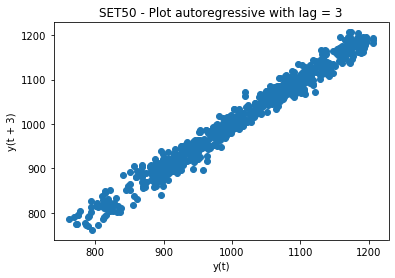

In [5]:
# Check Autocorrelation
#  https://pandas.pydata.org/docs/reference/api/pandas.plotting.lag_plot.html
fig, ax = plt.subplots()

for s in list_pilot_series():
    df_series = prep_series_for_ARIMA(dataset[s])
    df = df_series['2015-01-01':'2019-02-01']
    lag_plot(df['y_true'], lag=3)
    plt.title('%s - Plot autoregressive with lag = 3' % s)
    plt.show()

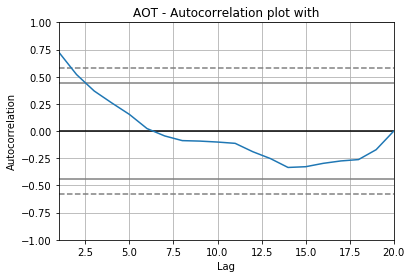

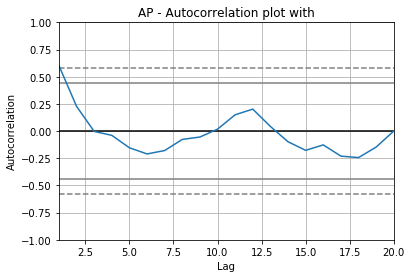

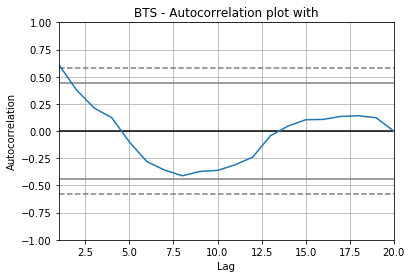

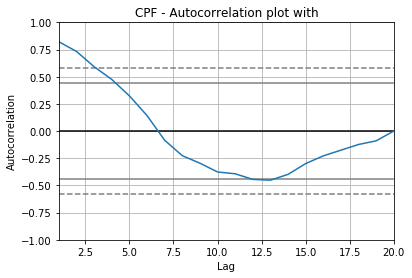

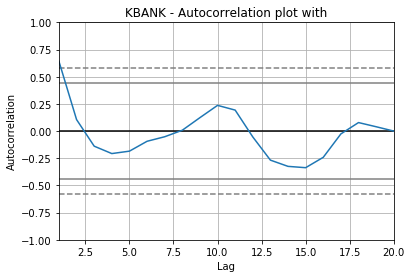

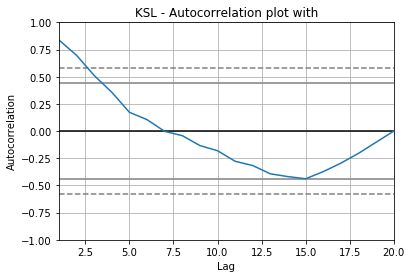

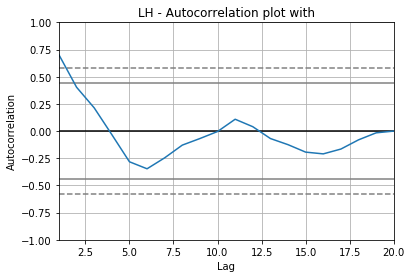

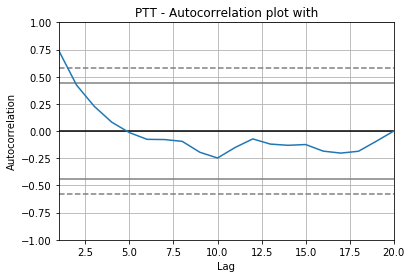

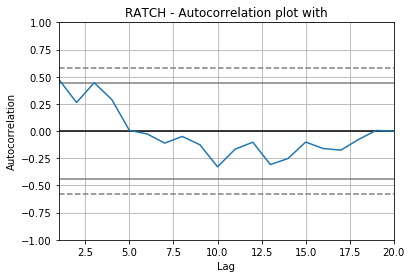

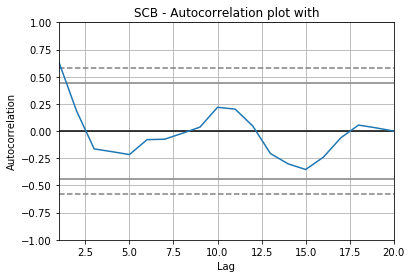

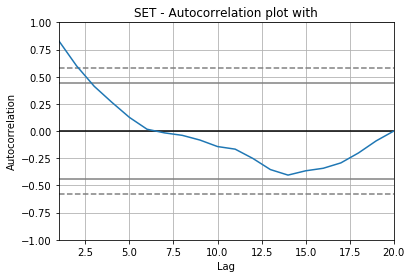

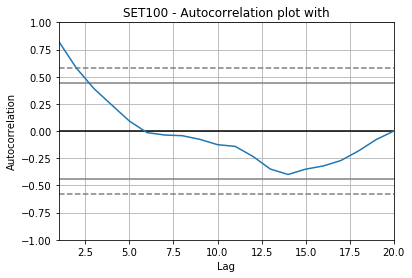

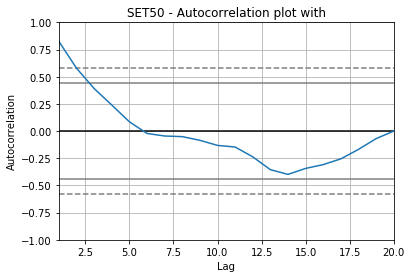

In [6]:
# Check Autocorrelation plot
#   https://pandas.pydata.org/docs/reference/api/pandas.plotting.autocorrelation_plot.html


from pandas.plotting import autocorrelation_plot
for s in list_pilot_series():
    df_series = prep_series_for_ARIMA(dataset[s])
    df = df_series['2015-01-01':'2015-02-01']
    autocorrelation_plot(df['y_true'])
    plt.title('%s - Autocorrelation plot with' % s)
    plt.show()

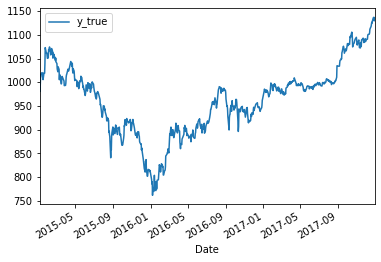

In [7]:
df = prep_series_for_ARIMA(dataset['SET50'])['2015':'2017']
df[['y_true']].plot()

In [8]:
class PredictionWindow:
    def __init__(self, history_obs, forecast_days, dataset, label_col):
        pass
    @property
    def first_obs(self):
        self.dataset

In [9]:
# Forecast one series

ndays=5 # Number of days into the future to predict. 
window=100 # Days of historical observations to use.
arima_order=(3,1,0)
series_id='DATA'

# window = 100  # window of history looking back
# ndays = 1     # 1-day horizon. Look 1-days into the future.
eval_window = window + ndays # the total period need for evaluation: history + future horizon.


# Number of observations in time-series.
all_obs = len(df)

all_obs

731

In [10]:
r = df.y_true.first('1d')
r

Date
2015-01-05    987.4
Name: y_true, dtype: float64

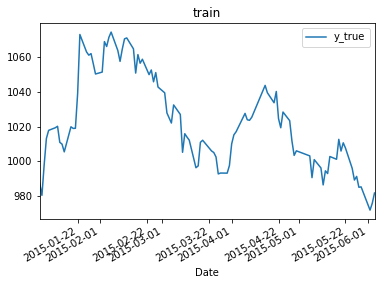

In [11]:
df[0:window][['y_true']].plot(title="train")

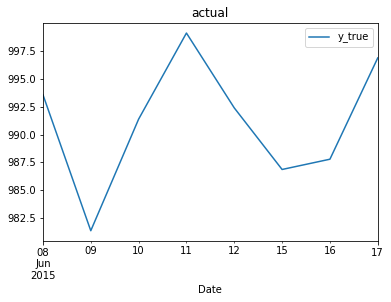

In [12]:
df[window+1:window+4+ndays][['y_true']].plot(title="actual")

In [13]:
eval_window

105

In [14]:
fit_df = df[0:eval_window]

history = fit_df[:window]['y_true']
model_predictions = [] # TODO: fill-me
model_error = []
model = ARIMA(history, order=arima_order) # (3,1,0) by default
model_fit = model.fit(disp=0)
output = model_fit.forecast(ndays)
# output = 1. forecasts 2. std.error 3. confident intervals

window, ndays, output

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(100, 5, (array([980.66415553, 980.19356109, 980.57710826, 980.49341146,
         980.3596207 ]),
  array([ 8.86423589, 12.55598043, 14.87270951, 17.10875905, 19.12859646]),
  array([[ 963.29057243,  998.03773864],
         [ 955.58429165, 1004.80283053],
         [ 951.42713326, 1009.72708325],
         [ 946.9608599 , 1014.02596301],
         [ 942.86826056, 1017.85098083]])))

In [15]:
pred_df = fit_df[['y_true']][window:window+ndays]
pred_df['y_pred'] = output[0]
pred_df['std_err'] = output[1]
# pred_df['confident_lower'] = output[2][0][0]  # TODO
# pred_df['confident_upper'] = output[2][0][1]  # 


pred_df #Resulting prediction frame

,y_true,y_pred,std_err
Date,,,
2015-06-05,994.33,980.664156,8.864236
2015-06-08,993.57,980.193561,12.555980
2015-06-09,981.38,980.577108,14.872710
2015-06-10,991.38,980.493411,17.108759
2015-06-11,999.10,980.359621,19.128596


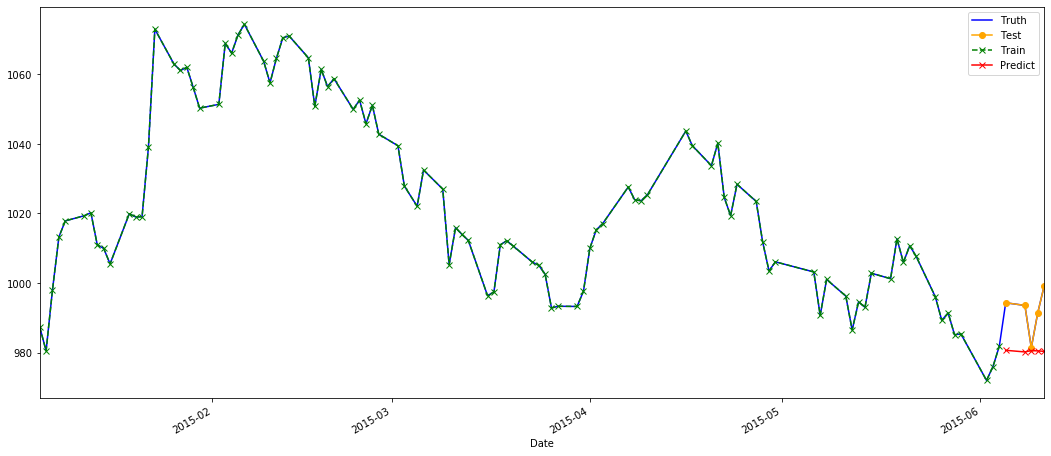

In [16]:
fig, ax = plt.subplots()
fit_df[['y_true']].plot(ax=ax, figsize=(18,8), color='Blue')
fit_df[['y_true']][window:window+ndays].plot(ax=ax, marker='o', color='Orange')
fit_df[['y_true']][0:window].plot(ax=ax, marker='x', linestyle='dashed', color='Green')
pred_df[['y_pred']].plot(ax=ax, marker='x', color='Red')

ax.legend(['Truth', 'Test', 'Train', 'Predict'])

In [17]:
pred_df.last('1d')

,y_true,y_pred,std_err
Date,,,
2015-06-11,999.1,980.359621,19.128596


In [18]:
from algorithm.arima_forecast import Prediction

In [19]:
p = Prediction()
p.fit_and_predict(df['2017-01-01':'2017-06-30'], '2017-05-22')

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/jovyan/ml_home/algorithm/arima_forecast.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['y_pred'] = output[0]
/home/jovyan/ml_home/algorithm/arima_forecast.py:78: SettingWithCopyWarning: 
A value is try

In [20]:
p.pred_df

,y_true,y_pred,std_err
Date,,,
2017-05-23,990.69,987.570240,4.351342
2017-05-24,991.62,987.745154,5.956558
2017-05-25,992.43,987.217147,7.359117
2017-05-26,991.97,987.315619,8.271991
2017-05-29,991.87,987.337042,9.128295


In [21]:
p.fit_df.tail()

,Date,Price,Open,High,Low,Vol.,Change %,Close,Volume,Date.1,Ticker,Type,Daily Return,y_true,t
Date,,,,,,,,,,,,,,,
2017-06-26,2017-06-26,997.44,998.82,1000.62,995.63,1.08B,0.12,997.44,1.080000e+09,2017-06-26,SET50,StockIndex,0.12,997.44,2017-06-26
2017-06-27,2017-06-27,999.60,999.46,1001.15,997.04,730.31M,0.22,999.60,7.303100e+08,2017-06-27,SET50,StockIndex,0.22,999.60,2017-06-27
2017-06-28,2017-06-28,997.33,999.26,1000.19,995.38,803.63M,-0.23,997.33,8.036300e+08,2017-06-28,SET50,StockIndex,-0.23,997.33,2017-06-28
2017-06-29,2017-06-29,995.10,1000.46,1003.26,993.77,1.46B,-0.22,995.10,1.460000e+09,2017-06-29,SET50,StockIndex,-0.22,995.10,2017-06-29
2017-06-30,2017-06-30,994.35,995.48,997.67,990.74,959.30M,-0.08,994.35,9.593000e+08,2017-06-30,SET50,StockIndex,-0.08,994.35,2017-06-30


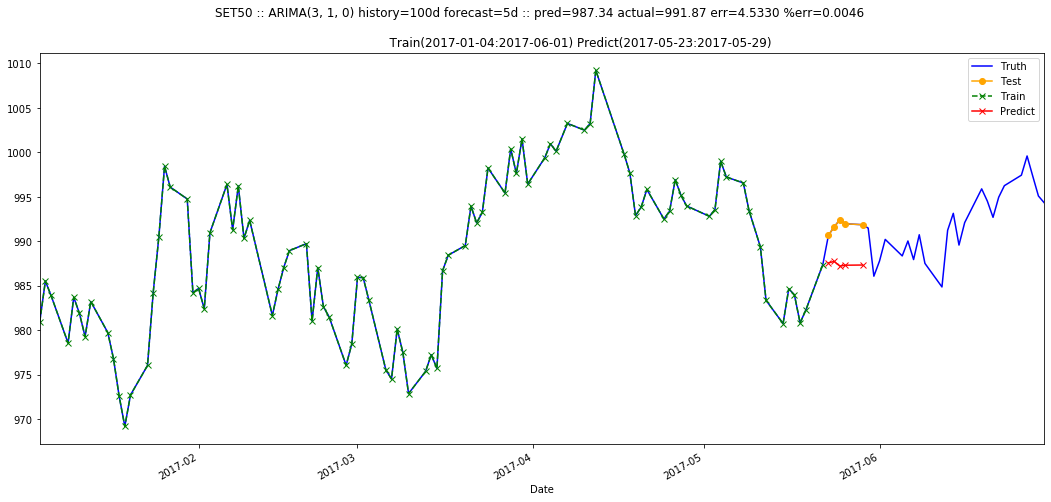

In [22]:
p.plot()

In [23]:
p.pred_df.last('1d')

,y_true,y_pred,std_err
Date,,,
2017-05-29,991.87,987.337042,9.128295


In [24]:
# Calculate total error.
res = p.pred_df.last('1d')
# The error is the difference between prediction and actual value in absolute term.
err = abs(res['y_pred'] - res['y_true']) .values[0]
err

4.5329580394961795

In [25]:
# The percentage error is the absolute error divide by the actual error.
pct_error = err / res['y_true'].values[0]
pct_error

0.004570113058663111

# Test  1, 3, 5, 7, 10, 15, 20, 30 days

df1

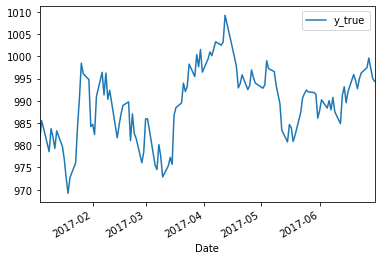

In [26]:
df1 = df['2017-01-01':'2017-06-30']
df1[['y_true']].plot()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,y_true,y_pred,std_err
Date,,,
2017-05-23,990.69,987.57024,4.351342


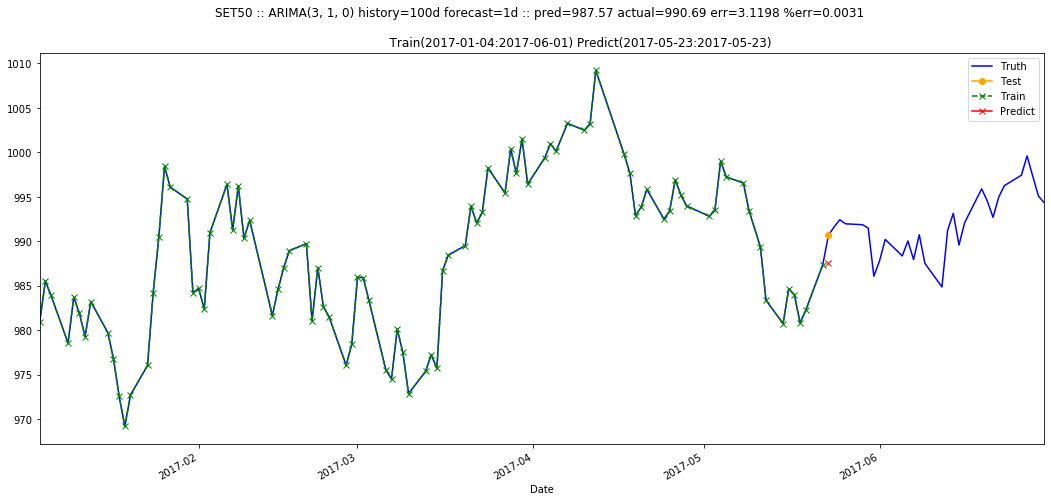

In [27]:
window = 100
p1 = Prediction()
p1.fit_and_predict(df1, today='2017-05-22', ndays=1, window=window)
p1.plot()
p1.pred_df

In [28]:
p.pred_df.last('1d').index.strftime('%Y-%m-%d').values[0]

'2017-05-29'

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

ValueError: Length of values does not match length of index

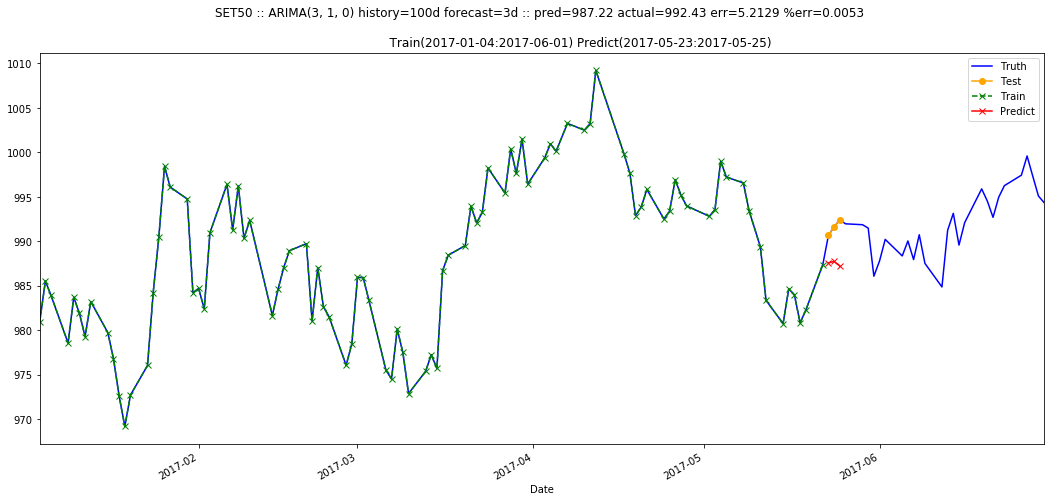

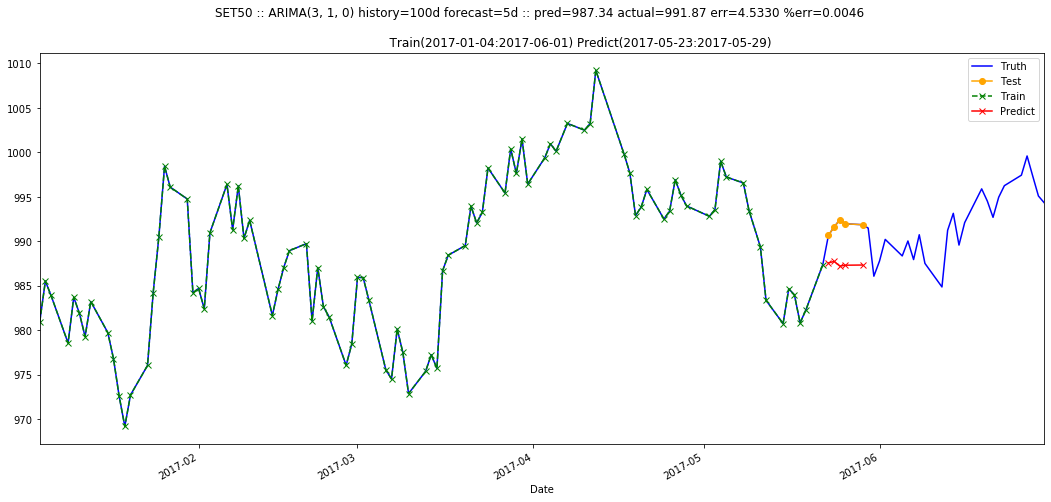

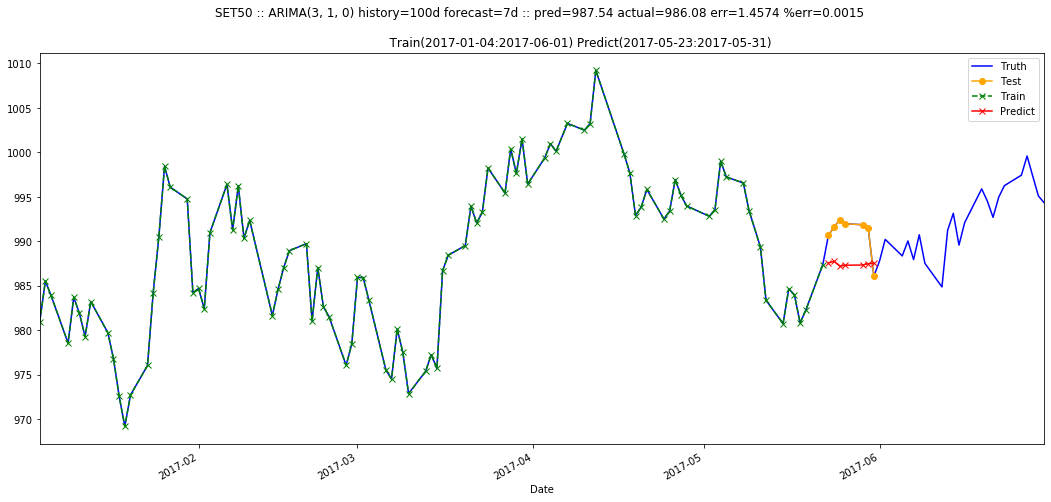

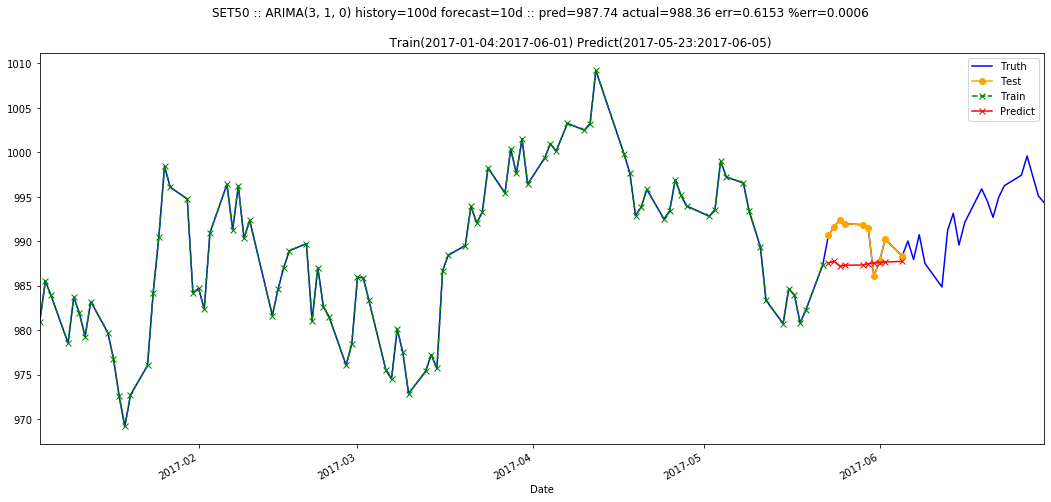

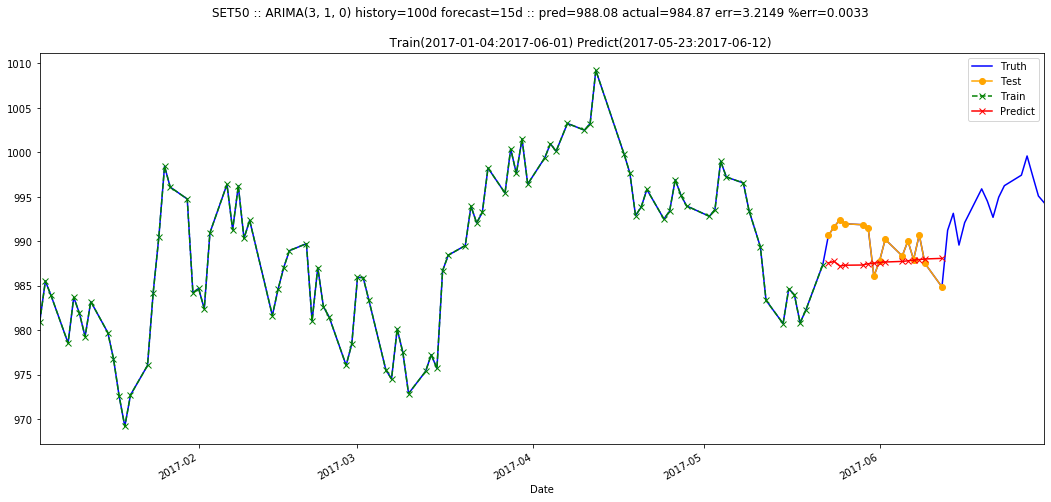

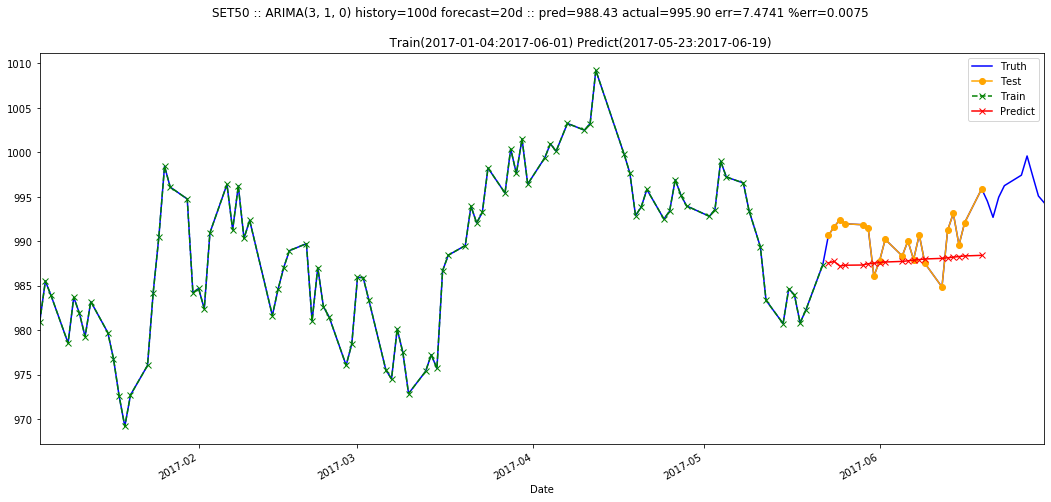

In [29]:
prediction = {}
for fh in [3, 5, 7, 10, 15, 20, 30]:
    p = Prediction()
    p.fit_and_predict(df1, today='2017-05-22', ndays=fh, window=window)
    p.plot()
    p.pred_df
    prediction[fh] = p

# Window 30, 50, 100

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

ValueError: Length of values does not match length of index

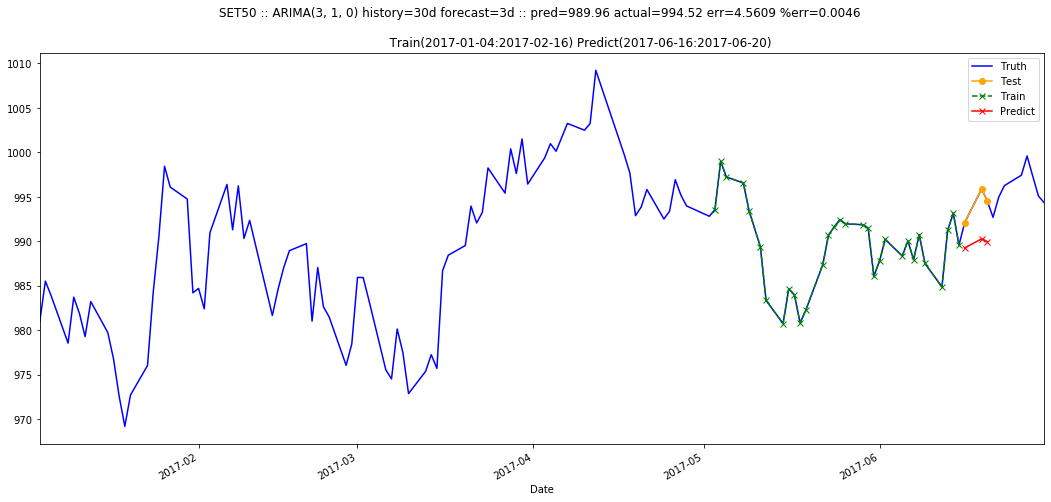

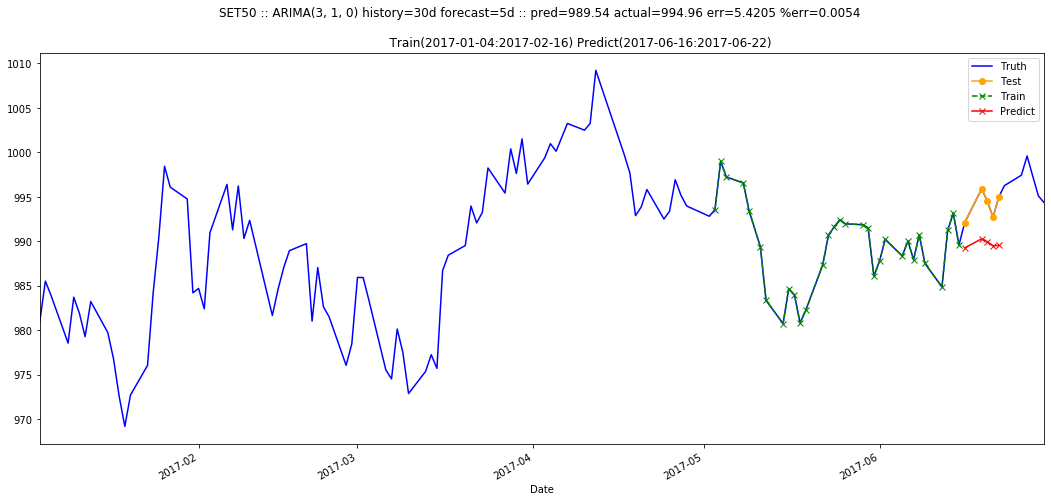

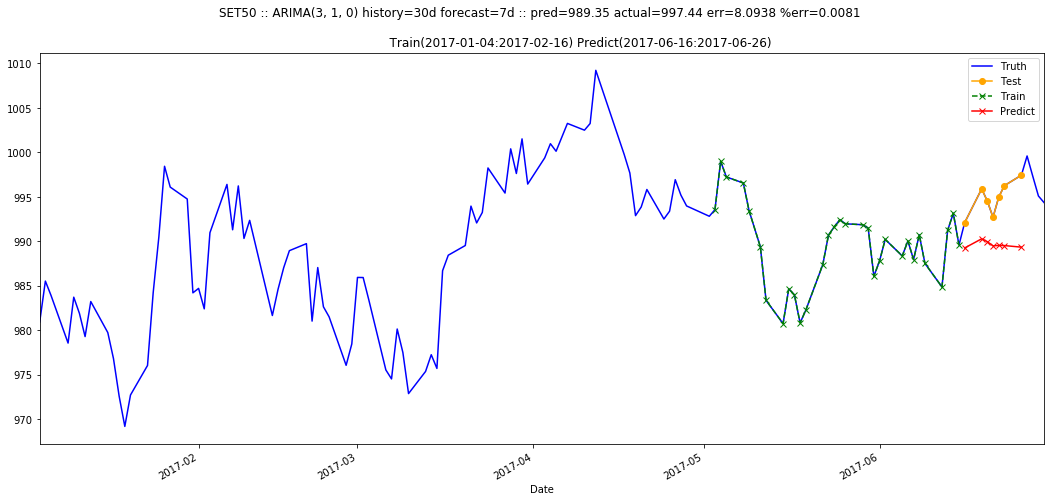

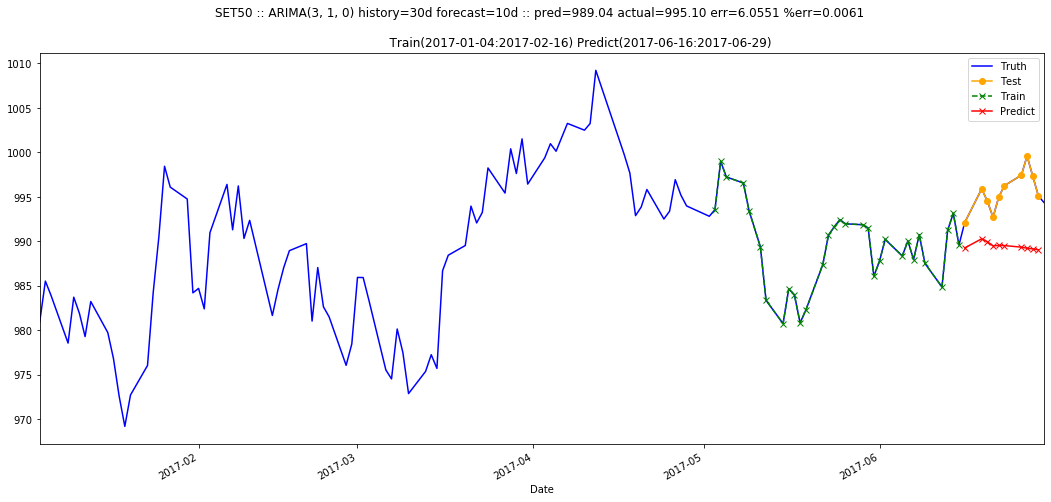

In [31]:
# prediction = {}
for w in [30,50]:
    for fh in [3, 5, 7, 10, 15, 20, 30]:
        p = Prediction()
        p.fit_and_predict(df1, today='2017-06-15', ndays=fh, window=w)
        p.plot()
        p.pred_df
        prediction[fh] = p

In [ ]:
# Collect data
#  - identify key with experimental control

prediction

In [ ]:
today = '2017-05-02'

df1[today:].index[0]

In [ ]:
df1[today:].index[0:2] # Today and tomorrow

In [ ]:
idx = df1[today:].index[1:1+ndays]

In [ ]:
df1[idx[0]:idx[-1]] # Future

In [ ]:
window = 50
idx = df1[:today].index[-1-window:-1]
df1[idx[0]:idx[-1]]  # Past

In [ ]:
idx

In [ ]:
today = '2015-06-02'
# idx = df[today:].index[0:1]
# df_today = df[idx[0],idx[1]

window=50
idx = df[:today].index[-1-window:-1] #
df_past = df[idx[0]:idx[-1]]

df_today = df[today:][0:1]

pd.concat([df_past, df_today])

In [ ]:
df_today